# Supervised Learning: Tree-Based Models

In this notebook, we attempted different tree-based supervised learning models. They are:
- Decision Tree
- Random Forest
- CatBoost
- XGBoost

This included running the model, testing it with the test set, scoring the model along with its classification report. 

**Conclusions from this notebook:**  

This was an attempt to document our process of choosing the most suitable model for this project. However, we did not use any of these models in the final ML pipeline. All the models attempted in this notebook and the other notebook produced high scores in Recall, F1 and accuracy. In the end, we chose to use Logistic Regression as it offered the most interpretable results, and we were better able to identify key features that TeejLab can use on the platform.

## Imports

In this section, we load all the packages required to run the notebook.

In [1]:
from sklearn import tree
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

## Read in train and test dataset

In this section:
- We load the training data, and look at first 5 values and shape. This data has already been cleaned, processed and new features created.
- Separate the data into X-train (features) and y-train (output)
- Use Oversampling (SMOTE) technique to create a balanced training data-set
- Define StandardScaler() for feature values

In [2]:
api_df = pd.read_excel("../../data/processed/preprocessed_train.xlsx")
api_test_df = pd.read_excel("../../data/processed/preprocessed_test.xlsx")
api_df.head()

,is_pii,is_fii,NRI score,authentication_processed,usage_base_processed,AI & Data Science,Business & Technology,Environment & Weather,Finance & Banking,GeoInformatics & Navigation,...,content-type,set-cookie,access-control-allow-origin,server,x-powered-by,x-aspnet-version,x-ratelimit-limit,metadata_fields_count,parameters_count,Risk_Label
0,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,Low
1,True,False,77.850013,1,2,0,0,0,0,0,...,0,0,0,1,0,0,0,6,1,Low
2,False,False,76.479613,1,2,0,1,0,0,0,...,0,0,0,1,0,0,0,3,1,Medium
3,True,False,76.479613,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,5,0,Low
4,True,False,77.850013,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,2,3,Low


In [3]:
api_df.shape

(1316, 53)

In [4]:
# X, y split
X_train, y_train = api_df.drop(columns=["Risk_Label"]), api_df["Risk_Label"]
X_test, y_test = api_test_df.drop(columns=["Risk_Label"]), api_test_df["Risk_Label"]

In [5]:
# Smote function
def create_smote(X, y, k_neighbors):
    oversample = SMOTE(k_neighbors = k_neighbors)
    X, y = oversample.fit_resample(X, y)
    return X, y

In [6]:
# Balance training data
X_train, y_train = create_smote(X_train, y_train, 2)

# Helper Code

In this section, we provide helper code that is used in the subsequent sections for evaluating the models. The function `mean_std_cross_val_scores()` computes the train score and test score for the `scoring_metric` using sklearn's `cross_validate()`. The final scores are returned in `results` dictionary.

In [7]:
results = {}
scoring_metric = ["f1_macro", "recall_macro"]

In [8]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

## 1. Decision Tree

In this section, we provide the implementation and analysis of `Random Forest` model. In the subsections below, the following tasks have been performed:
- Trained the model and obtained the recall values and f1-scores
- Tuned the hyperparameters of the model - `max_depth` and `max_tree_nodes` 
- Generated the classification report to evaluate class-wise performance
- Visualized the structure of the decision tree

#### Model fitting and scores

In [10]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
clf = tree.DecisionTreeClassifier(random_state=37, max_depth=6, criterion='gini')
clf = clf.fit(X_train, y_train)

In [11]:
model = DecisionTreeClassifier(random_state=37)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Model: Decision Tree")
print(f"F1 score: {metrics.f1_score(y_test, predictions, average='macro')}")
print(f"Recall: {metrics.recall_score(y_test, predictions, average='macro')}")

Model: Decision Tree
F1 score: 0.6647683424508477
Recall: 0.6642547342178509


#### Hyperparameter tuning

In [12]:
# max depth
clf_maxdepth = DecisionTreeClassifier(random_state=37, max_depth=5)
clf_maxdepth = clf_maxdepth.fit(X_train, y_train)
y_pred = clf_maxdepth.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9964601769911504


In [13]:
# max_leaf_nodes
clf_maxleafnode = DecisionTreeClassifier(random_state=37, max_leaf_nodes=5)
clf_maxleafnode = clf_maxleafnode.fit(X_train, y_train)
y_pred = clf_maxleafnode.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9911504424778761


#### Classification report

In [14]:
print(
    classification_report(
        y_test, predictions, target_names=["High", "Low Risk", "Medium"]
    )
)

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         0
    Low Risk       1.00      1.00      1.00       241
      Medium       1.00      1.00      1.00       324

    accuracy                           1.00       565
   macro avg       0.67      0.66      0.66       565
weighted avg       1.00      1.00      1.00       565



#### Decision Tree visualisation

[Text(0.5416666666666666, 0.9, 'is_pii <= 0.5\ngini = 0.667\nsamples = 1983\nvalue = [661, 661, 661]\nclass = Low'),
 Text(0.3333333333333333, 0.7, 'x0_Missing <= 0.5\ngini = 0.219\nsamples = 753\nvalue = [74, 18, 661]\nclass = Medium'),
 Text(0.16666666666666666, 0.5, 'x0_Broken Authentication <= 0.5\ngini = 0.119\nsamples = 79\nvalue = [74, 5, 0]\nclass = Low'),
 Text(0.08333333333333333, 0.3, 'gini = 0.0\nsamples = 5\nvalue = [0, 5, 0]\nclass = Low'),
 Text(0.25, 0.3, 'gini = 0.0\nsamples = 74\nvalue = [74, 0, 0]\nclass = Low'),
 Text(0.5, 0.5, 'is_fii <= 0.5\ngini = 0.038\nsamples = 674\nvalue = [0, 13, 661]\nclass = Medium'),
 Text(0.4166666666666667, 0.3, 'metadata_fields_count <= 0.5\ngini = 0.003\nsamples = 662\nvalue = [0, 1, 661]\nclass = Medium'),
 Text(0.3333333333333333, 0.1, 'gini = 0.0\nsamples = 1\nvalue = [0, 1, 0]\nclass = Low'),
 Text(0.5, 0.1, 'gini = 0.0\nsamples = 661\nvalue = [0, 0, 661]\nclass = Medium'),
 Text(0.5833333333333334, 0.3, 'gini = 0.0\nsamples = 12\

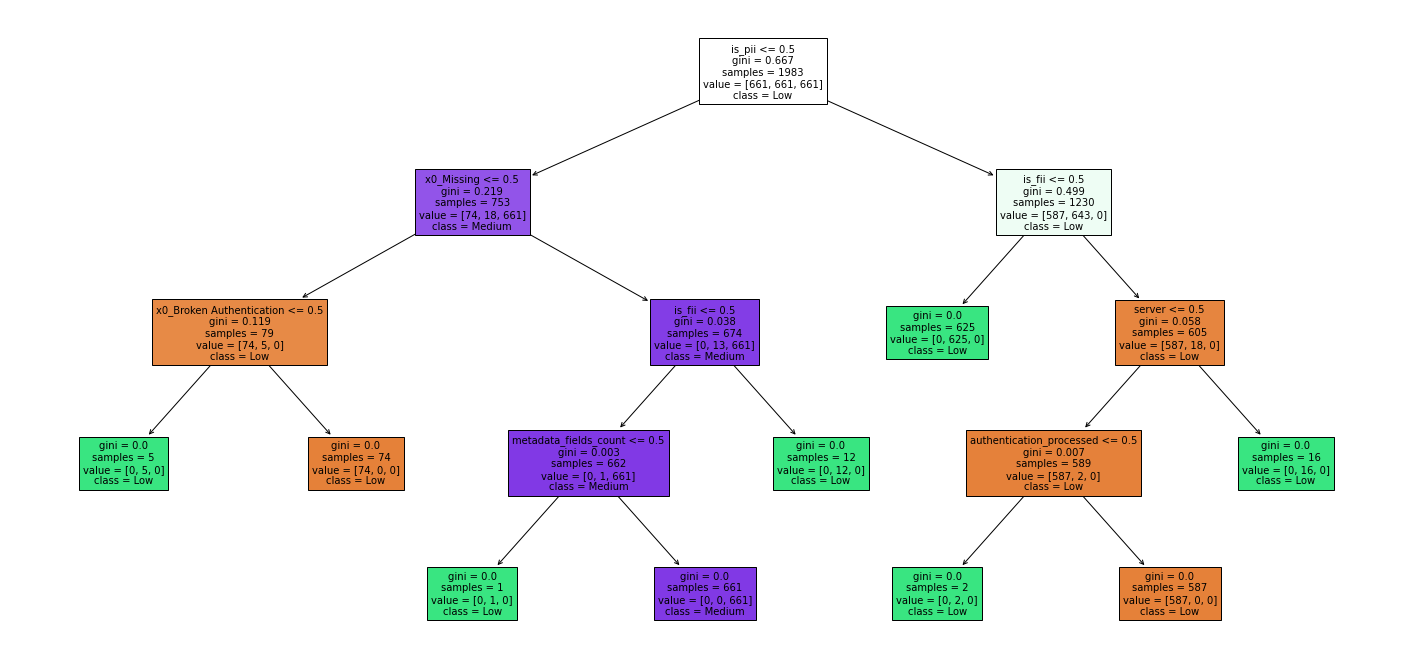

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(25, 12))
fn = list(X_train)
cn = list(y_train)
tree.plot_tree(clf,
               feature_names=fn,
               class_names=cn,
               fontsize=10,
               filled=True)

## 2. Random Forest

In this section, we provide the implementation and analysis of `Random Forest` model. In the subsections below, the following tasks have been performed:
- Trained the model and obtained the recall values and f1-scores
- Generated the classification report to evaluate class-wise performance

#### Model fitting and scores

In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
rf_clf = RandomForestClassifier(n_estimators=100, random_state=37, n_jobs=-1) # n_estimators = no. of trees in the forest
rf_clf = rf_clf.fit(X_train, y_train)

In [17]:
model = RandomForestClassifier(n_estimators=100, random_state=37, n_jobs=-1)
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print("Model: Random Forest")
print(f"F1 score: {metrics.f1_score(y_test, predictions, average='macro')}")
print(f"Recall: {metrics.recall_score(y_test, predictions, average='macro')}")

Model: Random Forest
F1 score: 0.665973665973666
Recall: 0.665283540802213


#### Classification report

In [18]:
print(
    classification_report(
        y_test, predictions, target_names=["High", "Low Risk", "Medium"]
    )
)

              precision    recall  f1-score   support

        High       0.00      0.00      0.00         0
    Low Risk       1.00      1.00      1.00       241
      Medium       1.00      1.00      1.00       324

    accuracy                           1.00       565
   macro avg       0.67      0.67      0.67       565
weighted avg       1.00      1.00      1.00       565



## 3. Comparing all the models including the above

In this section, we compare the performance improvement for four tree based models with regard to the Dummy model: Decision Tree, Random Forest, CatBoost, XGBoost. It is observed that the performance of all these ensemble models is similar. Hence, we select the Decision Tree model as it is fastest and most interpretable.

In [19]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=37),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=37),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=37),
    "XGBoost": XGBClassifier(random_state=37, eval_metric='logloss', verbosity=0),
}

In [20]:
dummy = DummyClassifier(strategy="stratified")
results["Dummy"] = mean_std_cross_val_scores(
    dummy, X_train, y_train, return_train_score=True, scoring=scoring_metric
)

In [21]:
for (name, model) in classifiers.items():
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    results[name] = mean_std_cross_val_scores(
        model, X_train, y_train, return_train_score=True, scoring=scoring_metric
    )

In [22]:
pd.DataFrame(results).T

,fit_time,score_time,test_f1_macro,train_f1_macro,test_recall_macro,train_recall_macro
Dummy,0.005 (+/- 0.001),0.008 (+/- 0.002),0.334 (+/- 0.028),0.326 (+/- 0.012),0.334 (+/- 0.028),0.326 (+/- 0.012)
Decision Tree,0.008 (+/- 0.003),0.008 (+/- 0.004),0.997 (+/- 0.002),1.000 (+/- 0.000),0.997 (+/- 0.002),1.000 (+/- 0.000)
Random Forest,0.175 (+/- 0.033),0.017 (+/- 0.001),0.998 (+/- 0.001),1.000 (+/- 0.000),0.998 (+/- 0.001),1.000 (+/- 0.000)
CatBoost,3.120 (+/- 0.467),0.008 (+/- 0.002),0.998 (+/- 0.001),1.000 (+/- 0.000),0.998 (+/- 0.001),1.000 (+/- 0.000)
XGBoost,0.506 (+/- 0.088),0.010 (+/- 0.006),0.998 (+/- 0.002),1.000 (+/- 0.000),0.998 (+/- 0.002),1.000 (+/- 0.000)
